Currently we're using a certain [hdf5 file](https://hrrrzarr.s3.amazonaws.com/index.html#grid/) to get indices from latitude and longitude to select HRRR Zarr data by chunk. Here I load that file, make enhancements, save it, and demonstrate use of the enhanced file.

## New file format creation

In [1]:
import numpy as np
import xarray as xr

def add_chunk_index_data(x_or_y, length):
    chunk_size = 150
    
    main_index = np.arange(length)
    ds[f"index_{x_or_y}"] = ((x_or_y), main_index)
    
    chunk_index = main_index // chunk_size
    ds[f"chunk_{x_or_y}"] = ((x_or_y), chunk_index)
    
    index_in_chunk = main_index % chunk_size
    ds[f"in_chunk_{x_or_y}"] = ((x_or_y), index_in_chunk)
    

grid_map = '../scratch/HRRR_latlon.h5'
ds = xr.open_dataset(grid_map, engine="netcdf4")
y_length, x_length = ds.latitude.shape
add_chunk_index_data("x", x_length)
add_chunk_index_data("y", y_length)
ds = ds.rename(phony_dim_1="x", phony_dim_0="y")

ds

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Dimensions without coordinates: x, y
Data variables:
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    index_x     (x) int64 0 1 2 3 4 5 6 7 ... 1792 1793 1794 1795 1796 1797 1798
    chunk_x     (x) int64 0 0 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 11 11 11
    in_chunk_x  (x) int64 0 1 2 3 4 5 6 7 8 ... 141 142 143 144 145 146 147 148
    index_y     (y) int64 0 1 2 3 4 5 6 7 ... 1052 1053 1054 1055 1056 1057 1058
    chunk_y     (y) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 6 6 6 7 7 7 7 7 7 7 7 7
    in_chunk_y  (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 148 149 0 1 2 3 4 5 6 7 8

The new data structure has all the indices we need to find the nearest gridpoint by latitude and longitude, find which chunk it's in, and find it based on the indices within the chunk.

But it's still very hard to look up by nearest latitude and longitude, since these depend on more than one dimension. Looking up by projection x and y makes a lot more sense, so we add those back in.

In [2]:
import cartopy.crs as ccrs

projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])
transform = np.vectorize(lambda i, j: projection.transform_point(i, j, ccrs.PlateCarree()))

grid_y = ds.isel(x=0)
grid_x = ds.isel(y=0)

_, proj_y = transform(grid_y.longitude, grid_y.latitude)
proj_x, _ = transform(grid_x.longitude, grid_x.latitude)

ds["x"] = proj_x
ds["y"] = proj_y

ds

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Coordinates:
  * x           (x) float64 -2.701e+06 -2.698e+06 ... 2.697e+06 2.7e+06
  * y           (y) float64 -1.581e+06 -1.578e+06 ... 1.584e+06 1.587e+06
Data variables:
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    index_x     (x) int64 0 1 2 3 4 5 6 7 ... 1792 1793 1794 1795 1796 1797 1798
    chunk_x     (x) int64 0 0 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 11 11 11
    in_chunk_x  (x) int64 0 1 2 3 4 5 6 7 8 ... 141 142 143 144 145 146 147 148
    index_y     (y) int64 0 1 2 3 4 5 6 7 ... 1052 1053 1054 1055 1056 1057 1058
    chunk_y     (y) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 6 6 6 7 7 7 7 7 7 7 7 7
    in_chunk_y  (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 148 149 0 1 2 3 4 5 6 7 8

In [3]:
ds.to_netcdf("HRRR_chunk_index.h5", engine="scipy")

## Using the new file

Now let's demonstrate using this enhanced file to get some example data closest to SLC.

In [4]:
ds = xr.open_dataset("HRRR_chunk_index.h5", engine="scipy")
ds

<xarray.Dataset>
Dimensions:     (x: 1799, y: 1059)
Coordinates:
  * x           (x) float64 -2.701e+06 -2.698e+06 ... 2.697e+06 2.7e+06
  * y           (y) float64 -1.581e+06 -1.578e+06 ... 1.584e+06 1.587e+06
Data variables:
    index_x     (x) int32 ...
    chunk_x     (x) int32 ...
    in_chunk_x  (x) int32 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    index_y     (y) int32 ...
    chunk_y     (y) int32 ...
    in_chunk_y  (y) int32 ...

First, we need to get the nearest point:

In [5]:
import cartopy.crs as ccrs

projection = ccrs.LambertConformal(central_longitude=-97.5,
                             central_latitude=38.5,
                             standard_parallels=[38.5])

x, y = projection.transform_point(-111.8910, 40.7608, ccrs.PlateCarree())

nearest_point = ds.sel(x=x, y=y, method="nearest")

print(nearest_point)

<xarray.Dataset>
Dimensions:     ()
Coordinates:
    x           float64 -1.211e+06
    y           float64 3.46e+05
Data variables:
    index_x     int32 496
    chunk_x     int32 3
    in_chunk_x  int32 46
    latitude    float64 ...
    longitude   float64 ...
    index_y     int32 644
    chunk_y     int32 4
    in_chunk_y  int32 44


Next, we need to get the chunk url to download from S3:

In [6]:
chunk_id = '{}.{}'.format(nearest_point.chunk_y.values, nearest_point.chunk_x.values)
print(chunk_id)

4.3


In [12]:
root_path = "sfc/20210108/20210108_00z_fcst.zarr/surface/TMP/surface/TMP/0."
url = root_path + chunk_id

import boto3
from botocore import UNSIGNED
from botocore.config import Config

s3 = boto3.resource(service_name='s3', region_name='us-west-1', config=Config(signature_version=UNSIGNED))
obj = s3.Object('hrrrzarr', url)
obj = obj.get()['Body'].read()

We do have to manually decompress this, there's probably no way getting around that given that we're only reading part of the zarr array so APIs don't handle everything nicely for us.

In [16]:
import numcodecs as ncd

# Surface-level pressure requires dtype="<f4", the default should be correct for everything else
def decompress_fcst_chunk(data, dtype="<f2"):
    buffer = ncd.blosc.decompress(data)
    chunk = np.frombuffer(buffer, dtype=dtype)
    entry_size = 22500
    data_array = np.reshape(chunk, (len(chunk)//entry_size, 150, 150))
    return data_array

chunk_data = decompress_fcst_chunk(obj)

Now that we have the data as a simple numpy array, we can use the in-chunk indices to access the data at our point:

In [17]:
slc_forecast = chunk_data[:, nearest_point.in_chunk_x.values, nearest_point.in_chunk_y.values]
slc_forecast

array([273.8, 272.2, 271.2, 268.2, 268. , 268.2, 268.2, 268.2, 268.2,
       268.2, 268.5, 267.8, 266.8, 266. , 265.5, 267.8, 273.8, 278.5,
       281.8, 283.5, 284.2, 283.5, 281.2, 277.8, 273.8, 272. , 272.8,
       272.8, 272.8, 271. , 269.2, 268.2, 269. , 269. , 270.2, 270.2,
       271.2, 271.8, 272.2, 272.5, 273.2, 273.5, 275.5, 277.2, 277.5,
       277.2, 276.5, 273.8], dtype=float16)

Let's visualize this:

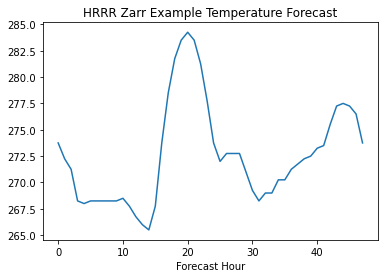

In [18]:
import matplotlib.pyplot as plt

plt.title("HRRR Zarr Example Temperature Forecast")
plt.xlabel("Forecast Hour")
plt.plot(slc_forecast)